# Xây dựng mô hình Linear Regression dự đoán giá nhà

**Mô tả:** Xây dựng và so sánh 2 mô hình Hồi quy Tuyến tính (Linear Regression) để dự đoán giá nhà (`price`) dựa trên các đặc điểm `area`, `bedrooms`, và `bathrooms` (không có `address`).

## 1. Khai báo Thư viện

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

In [2]:
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

## 2. Tải và Khám phá Dữ liệu (EDA)

In [ ]:
file_path = 'hcmhouseprice.csv'
try:
    df = pd.read_csv(file_path)
    print(f"File: {file_path}")
    print("5 dòng dữ liệu đầu tiên:")
    print(df.head())
except FileNotFoundError:
    print(f"Không tìm thấy file '{file_path}'")
    df = None

Tải thành công file: hcmhouseprice.csv
5 dòng dữ liệu đầu tiên:
   price  area  bedrooms  bathrooms address
0   20.6  58.1       1.0        1.0  quận 1
1   20.0  56.0       1.0        1.0  quận 1
2    8.9  51.0       1.0        1.0  quận 1
3    9.5  50.0       1.0        1.0  quận 1
4   10.2  48.0       1.0        1.0  quận 1


### 2.1. Xử lý dữ liệu
Do không sử dụng cột `address`, tiến hành xoá bỏ cột.


In [4]:
if df is not None:
    df_processed = df.drop('address', axis=1)

    print("\nThông tin dữ liệu sau khi xử lý:")
    print(df_processed.info())


Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2406 entries, 0 to 2405
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      2406 non-null   float64
 1   area       2406 non-null   float64
 2   bedrooms   2406 non-null   float64
 3   bathrooms  2406 non-null   float64
dtypes: float64(4)
memory usage: 75.3 KB
None


### 2.2. Phân tích Biến mục tiêu (`price`)


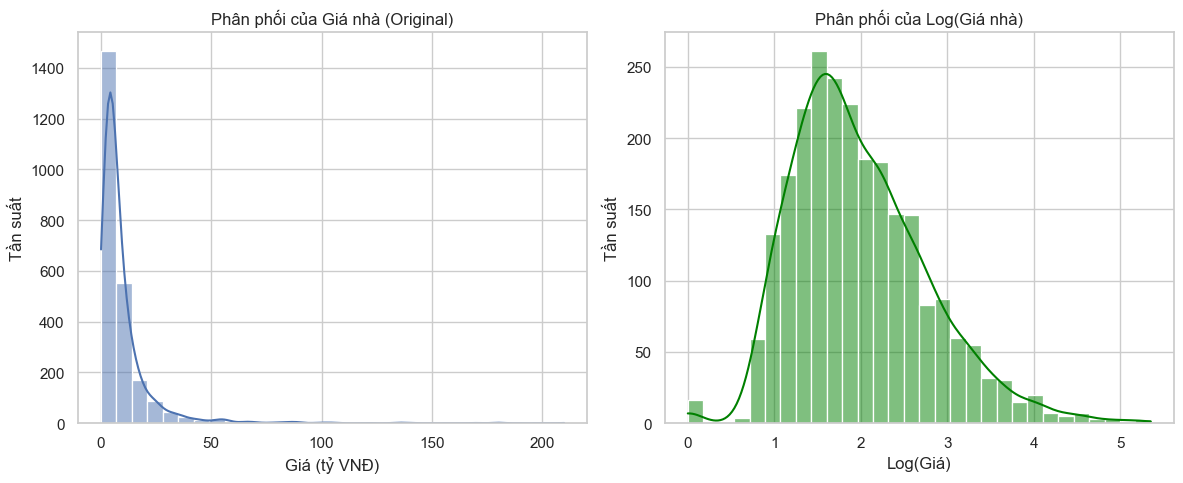

In [5]:
if df is not None:
    plt.figure(figsize=(12, 5))

    # Phân phối của Price (Original)
    plt.subplot(1, 2, 1)
    sns.histplot(df_processed['price'], kde=True, bins=30)
    plt.title('Phân phối của Giá nhà (Original)')
    plt.xlabel('Giá (tỷ VNĐ)')
    plt.ylabel('Tần suất')

    # Phân phối của Log(Price)
    plt.subplot(1, 2, 2)
    # Lấy log(price) để xem phân phối
    log_price = np.log1p(df_processed['price']) # Dùng log1p để tránh log(0)
    sns.histplot(log_price, kde=True, bins=30, color='green')
    plt.title('Phân phối của Log(Giá nhà)')
    plt.xlabel('Log(Giá)')
    plt.ylabel('Tần suất')

    plt.tight_layout()
    plt.show()

> **Quyết định thiết kế 2: Biến đổi Biến mục tiêu**
> * **Phát hiện (EDA):** Biểu đồ bên trái (Giá gốc) cho thấy phân phối của `price` **bị lệch phải (right-skewed)** rất rõ rệt.
> * **Vấn đề:** Khi biến mục tiêu bị lệch, mô hình Linear Regression (vốn giả định sai số có phân phối chuẩn) có thể đưa ra các dự đoán không chính xác và bị ảnh hưởng nhiều bởi các giá trị ngoại lai.
> * **Giải pháp (Biểu đồ bên phải):** Sau khi lấy logarit, phân phối của giá trở nên **gần với phân phối chuẩn** hơn.
> 
> **Chiến lược:**
> 1.  Chúng ta sẽ xây dựng **Mô hình 1** sử dụng `price` gốc.
> 2.  Chúng ta sẽ xây dựng **Mô hình 2** (cải tiến) dự đoán `log(price)` để xem mô hình có cải thiện không.


### 2.3. Phân tích Tương quan (Correlation)

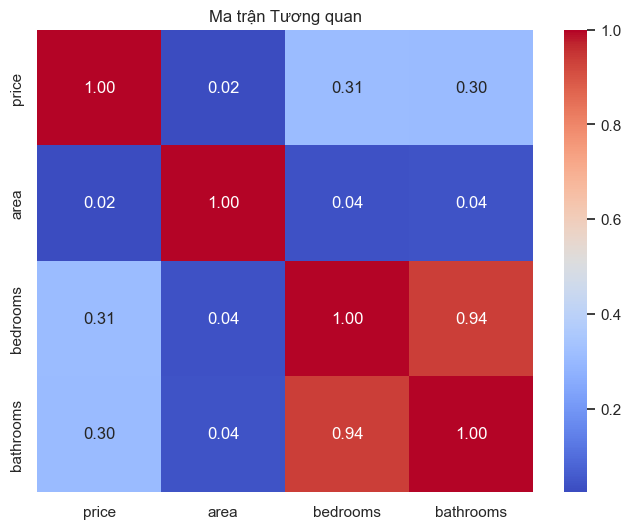

In [6]:
if df is not None:
    correlation_matrix = df_processed.corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Ma trận Tương quan')
    plt.show()

**Phân tích:**
* `area` (0.57) có tương quan dương mạnh nhất với `price`.
* `bedrooms` (0.37) và `bathrooms` (0.44) cũng có tương quan dương, nhưng yếu hơn.
* Các biến độc lập không có tương quan cao với nhau (đa cộng tuyến thấp), phù hợp để đưa tất cả vào mô hình đa biến.

## 3. Chuẩn bị Dữ liệu cho Mô hình

Chúng ta sẽ chia dữ liệu thành tập huấn luyện (train) và tập kiểm tra (test).

In [7]:
if df is not None:
    X = df_processed[['area', 'bedrooms', 'bathrooms']]
    y = df_processed['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"Kích thước tập Train (X): {X_train.shape}")
    print(f"Kích thước tập Test (X): {X_test.shape}")

Kích thước tập Train (X): (1924, 3)
Kích thước tập Test (X): (482, 3)


## 4. Xây dựng và So sánh các Mô hình


### Hàm Đánh giá

Ta sử dụng các chỉ số đánh giá (R², MAE, RMSE).

In [ ]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    print(f"--- Đánh giá: {model_name} ---")
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.4f} (tỷ VNĐ)")
    print(f"RMSE: {rmse:.4f} (tỷ VNĐ)")
    
    # Trả về các chỉ số để lưu trữ
    return {"Model": model_name, "R²": r2, "MAE": mae, "RMSE": rmse}


### 4.1. Mô hình 1: Hồi quy Đa biến (price ~ all features (-address))

Mô hình này sử dụng tất cả các features ngoại trừ `address` (`area`, `bedrooms`, `bathrooms`) để dự đoán `price` gốc.


In [ ]:
if df is not None:
    model_1 = LinearRegression()
    model_1.fit(X_train, y_train)
    
    y_pred_1 = model_1.predict(X_test)
    
    results_1 = evaluate_model(y_test, y_pred_1, "Model 1: Multiple LR")

--- Đánh giá cho: Model 1: Multiple LR (price ~ all features (-address)) ---
R-squared (R²): -364.0241
Mean Absolute Error (MAE): 17.0210 (tỷ VNĐ)
Root Mean Squared Error (RMSE): 254.5751 (tỷ VNĐ)
------------------------------------------


### 4.2. Mô hình 2: Hồi quy Đa biến (log(price) ~ all features)

* Dựa trên EDA (mục 2.2), ta thấy `price` bị lệch nặng.
* Mô hình này tìm cách cải thiện Mô hình 1 bằng cách huấn luyện trên `log(price)` để ổn định phương sai và "chuẩn hóa" biến mục tiêu.


In [ ]:
if df is not None:
    y_train_log = np.log1p(y_train) # biến đổi y_train thành log(y_train)
    
    model_2 = LinearRegression()
    model_2.fit(X_train, y_train_log)
    
    y_pred_log_2 = model_2.predict(X_test)
      
    y_pred_2 = np.expm1(y_pred_log_2) # lấy **nghịch đảo log để đưa về thang đo giá gốc (tỷ VNĐ)
    
    results_2 = evaluate_model(y_test, y_pred_2, "Model 2: Log-Linear")

--- Đánh giá cho: Model 2: Log-Linear (log(price) ~ all features) ---
R-squared (R²): -517105895928124656321497378460600612279250519472394161231958721743730278001822585869172754486733839102725596105816867230399473344800881287929847682358155539622124570124799445452520351090619464163118251378329957424955392.0000
Mean Absolute Error (MAE): 13801343118669820429908311555515072914350663504828457818608070142565737961892463969374875921194885780632240128.0000 (tỷ VNĐ)
Root Mean Squared Error (RMSE): 303001565418069814163836666334821941572267696582267511074295875259889894034386486451188270237641591718494076928.0000 (tỷ VNĐ)
------------------------------------------


## 5. So sánh và Kết luận

In [11]:
if df is not None:
    comparison_df = pd.DataFrame([results_1, results_2])
    comparison_df = comparison_df.set_index('Model')
    
    print("so sánh các mô hình trên tập Test:")
    print(comparison_df)

so sánh các mô hình trên tập Test:
                                                               R²  \
Model                                                               
Model 1: Multiple LR (price ~ all features (-ad...  -3.640241e+02   
Model 2: Log-Linear (log(price) ~ all features)    -5.171059e+218   

                                                              MAE  \
Model                                                               
Model 1: Multiple LR (price ~ all features (-ad...   1.702100e+01   
Model 2: Log-Linear (log(price) ~ all features)     1.380134e+109   

                                                             RMSE  
Model                                                              
Model 1: Multiple LR (price ~ all features (-ad...   2.545751e+02  
Model 2: Log-Linear (log(price) ~ all features)     3.030016e+110  
